## 1번 문제
모두의딥러닝 시즌2 강의의 longsequence 코드 lstm 모델 적용해보기.
https://github.com/deeplearningzerotoall/PyTorch/blob/master/RNN/4-longseq.ipynb

In [1]:
import torch
import torch.optim as optim
import numpy as np

In [2]:
# Random seed to make results deterministic and reproducible
torch.manual_seed(0)

In [3]:
sentence = ("if you want to build a ship, don't drum up people together to "
            "collect wood and don't assign them tasks and work, but rather "
            "teach them to long for the endless immensity of the sea.")

In [4]:
# make dictionary
char_set = list(set(sentence))
char_dic = {c: i for i, c in enumerate(char_set)}

In [40]:
char_dic

{'y': 0,
 'i': 1,
 'o': 2,
 'b': 3,
 ',': 4,
 'w': 5,
 '.': 6,
 'h': 7,
 'u': 8,
 'd': 9,
 'k': 10,
 't': 11,
 'c': 12,
 'f': 13,
 'n': 14,
 ' ': 15,
 's': 16,
 "'": 17,
 'l': 18,
 'a': 19,
 'm': 20,
 'e': 21,
 'g': 22,
 'p': 23,
 'r': 24}

In [5]:
# hyper parameters
dic_size = len(char_dic)
hidden_size = len(char_dic)
sequence_length = 10  # Any arbitrary number
learning_rate = 0.1

In [6]:
# data setting
x_data = []
y_data = []

for i in range(0, len(sentence) - sequence_length): 
    #길이가 10이 되게 자른 chunk를 len(sentence)-sequence_length만큼 문자를 한칸씩 넘어가면서 만들어줄것
    x_str = sentence[i:i + sequence_length]
    y_str = sentence[i + 1: i + sequence_length + 1]
    print(i, x_str, '->', y_str)

    x_data.append([char_dic[c] for c in x_str])  # x str to index 문자열을 index형태로 바꾸어줌
    y_data.append([char_dic[c] for c in y_str])  # y str to index

x_one_hot = [np.eye(dic_size)[x] for x in x_data] #np.eye 사용, one-hot vector로 만들어줌

0 if you wan -> f you want
1 f you want ->  you want 
2  you want  -> you want t
3 you want t -> ou want to
4 ou want to -> u want to 
5 u want to  ->  want to b
6  want to b -> want to bu
7 want to bu -> ant to bui
8 ant to bui -> nt to buil
9 nt to buil -> t to build
10 t to build ->  to build 
11  to build  -> to build a
12 to build a -> o build a 
13 o build a  ->  build a s
14  build a s -> build a sh
15 build a sh -> uild a shi
16 uild a shi -> ild a ship
17 ild a ship -> ld a ship,
18 ld a ship, -> d a ship, 
19 d a ship,  ->  a ship, d
20  a ship, d -> a ship, do
21 a ship, do ->  ship, don
22  ship, don -> ship, don'
23 ship, don' -> hip, don't
24 hip, don't -> ip, don't 
25 ip, don't  -> p, don't d
26 p, don't d -> , don't dr
27 , don't dr ->  don't dru
28  don't dru -> don't drum
29 don't drum -> on't drum 
30 on't drum  -> n't drum u
31 n't drum u -> 't drum up
32 't drum up -> t drum up 
33 t drum up  ->  drum up p
34  drum up p -> drum up pe
35 drum up pe -> rum up peo
36

In [7]:
# transform as torch tensor variable; 만든 데이터를 파이토치 텐서 타입으로 바꾸기
X = torch.FloatTensor(x_one_hot)
Y = torch.LongTensor(y_data)

In [8]:
# declare RNN + FC
class Net(torch.nn.Module):#모듈이 내부적으로 어떤 하위모듈을 쓰는지 정의
    def __init__(self, input_dim, hidden_dim, layers):
        super(Net, self).__init__()
        self.rnn = torch.nn.RNN(input_dim, hidden_dim, num_layers=layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, hidden_dim, bias=True)

    def forward(self, x): # x라는 input을 넣고 네트워크를 계산할 때 어떻게 계산할지 정의
        x, _status = self.rnn(x)
        x = self.fc(x)
        return x #두 layer의 RNN지나고나서, FC(linear 모듈을 지나고 output이 나오게 되는 구조!

In [9]:
# declare RNN + FC
class Net(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, layers):
        super(Net, self).__init__()
        self.rnn = torch.nn.RNN(input_dim, hidden_dim, num_layers=layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, hidden_dim, bias=True)

    def forward(self, x):
        x, _status = self.rnn(x)
        x = self.fc(x)
        return x


net = Net(dic_size, hidden_size, 2)

In [10]:
# loss & optimizer setting
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), learning_rate)

In [11]:
# start training
for i in range(100):
    optimizer.zero_grad() #gradient가 매 루프마다 리셋되도록
    outputs = net(X) #아까 정의한 모델에 input x 넣어서 output 나오도록
    loss = criterion(outputs.view(-1, dic_size), Y.view(-1))
    loss.backward() #gradient 계산됨 
    optimizer.step() #방금 계산한 gradient 값들로 parameter 업데이트

    results = outputs.argmax(dim=2) #prediction 확률이 가장 큰 결과값들 구해옴
    predict_str = ""
    for j, result in enumerate(results):
        # print(i, j, ''.join([char_set[t] for t in result]), loss.item())
        if j == 0: #맨처음엔 seq_length만큼의 길이의 character들 만들고
            predict_str += ''.join([char_set[t] for t in result])
        else: #그 이후부턴 맨 마지막글자를 제외하곤 기존의 것과 겹치기 때문에 맨 마지막 글자만 가져와서 붙임
            predict_str += char_set[result[-1]]

    print(predict_str)

cfhfhfccbffchhchfcfhclhchclhfchfchchhfhcffcffchhcchhhcfcchhfcchhhhchfcbbblclfcchhfchclhchhfcfcchcffcfcclfccbbbfffhffchlfcchbfchhfchcchcfcchhfhcfhhbfccccfhfccccchccfccfhchfchcccccl
                                                                                                                                                                                   
 eee eee eee e ee e e e e e e e e eeee e e e e ee eeeeeee e e e eeee ee ee  e e eee ee eeeee  eeeee e  e e ee e eee e e eeee e e eeee  e  e  e e  e eeee eee  eee e eee e e e e e e
 oth  tht hu   uo n o  on n       n no    ho n    h     o oh          u h u   h        o        on  h h       ho   un n non o   oo     o  h o  o  ho   h   o  h,   h    n n n n  o 
 ttt t t t t  t t t t t   t   t t  t t t tt t tt tt t t t t  ttt tt t t  tt t t   tt   ttt t    t ttttttt t  tt t t t   tt t t t t    t tt t ttt ttt t t t ttttt  t t t t   t  tt t
lalt a a a t  l tlt b t'twl t alt wl a t tl a t bta a a a t  l  aalla . l a t t t t.t  a t i il a t 

## 2번 문제
 https://tutorials.pytorch.kr/intermediate/char_rnn_classification_tutorial.html 따라해보기


18개 언어로 된 수천 개의 성(姓)을 훈련시키고, 철자에 따라 이름이 어떤 언어인지 예측합니다.

In [12]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

In [13]:
def findFiles(path): return glob.glob(path)

print(findFiles('C:/data/names/*.txt')) #파일 위치 주의하기....

['C:/data/names\\Arabic.txt', 'C:/data/names\\Chinese.txt', 'C:/data/names\\Czech.txt', 'C:/data/names\\Dutch.txt', 'C:/data/names\\English.txt', 'C:/data/names\\French.txt', 'C:/data/names\\German.txt', 'C:/data/names\\Greek.txt', 'C:/data/names\\Irish.txt', 'C:/data/names\\Italian.txt', 'C:/data/names\\Japanese.txt', 'C:/data/names\\Korean.txt', 'C:/data/names\\Polish.txt', 'C:/data/names\\Portuguese.txt', 'C:/data/names\\Russian.txt', 'C:/data/names\\Scottish.txt', 'C:/data/names\\Spanish.txt', 'C:/data/names\\Vietnamese.txt']


In [14]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

In [41]:
all_letters

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'"

In [15]:
# 유니코드 문자열을 ASCII로 변환, https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))


Slusarski


In [16]:
# 각 언어의 이름 목록인 category_lines 사전 생성
category_lines = {}
all_categories = []

In [17]:
# 파일을 읽고 줄 단위로 분리
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('C:/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [18]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [19]:
import torch

In [20]:
# all_letters 로 문자의 주소 찾기, 예시 "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

In [21]:
# 검증을 위해서 한개의 문자를 <1 x n_letters> Tensor로 변환
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

In [22]:
# 한 줄(이름)을  <line_length x 1 x n_letters>,
# 또는 One-Hot 문자 벡터의 Array로 변경
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [23]:
print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [24]:
import torch.nn as nn

In [25]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [26]:
input = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [27]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8445, -2.8727, -3.0294, -2.9006, -2.8926, -2.9646, -2.8060, -2.7947,
         -3.0138, -2.8262, -2.8908, -2.9072, -2.7824, -2.9781, -2.8192, -2.8924,
         -2.9296, -2.9268]], grad_fn=<LogSoftmaxBackward>)


In [28]:
#네트워크 출력(각 카테고리의 우도)으로 가장 확률이 높은 카테고리 이름(언어)과 카테고리 번호 반환
def categoryFromOutput(output):
    top_n, top_i = output.topk(1) # 텐서의 가장 큰 값 및 주소
    category_i = top_i[0].item()     # 텐서에서 정수 값으로 변경
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Polish', 12)


In [29]:
import random

In [30]:
#학습 예시(하나의 이름과 그 언어)를 얻는 빠른 방법도 필요
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

In [31]:
for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Russian / line = V'Yuhin
category = Greek / line = Paschalis
category = Vietnamese / line = Luong
category = Dutch / line = Agthoven
category = Spanish / line = Arechavaleta
category = German / line = Ingersleben
category = Irish / line = Mcneil
category = Arabic / line = Daher
category = Chinese / line = Wang
category = Arabic / line = Fakhoury


In [32]:
criterion = nn.NLLLoss() #loss설정
#RNN의 마지막 계층이 nn.LogSoftmax 이므로 손실 함수로 nn.NLLLoss 가 적합합니다.

In [33]:
learning_rate = 0.005 # 이것을 너무 높게 설정하면 발산할 수 있고, 너무 낮으면 학습이 되지 않을 수 있습니다.

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # 매개변수의 경사도에 학습률을 곱해서 그 매개변수의 값에 더합니다.
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

#각 학습 루프는 다음과 같습니다:
#입력과 목표 Tensor 생성
#0 로 초기화된 은닉 상태 생성
#각 문자를 읽기
#다음 문자를 위한 은닉 상태 유지
#목표와 최종 출력 비교
#역전파
#출력과 손실 반환

In [34]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

In [35]:
# 도식화를 위한 손실 추적
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # iter 숫자, 손실, 이름, 추측 화면 출력
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # 현재 평균 손실을 전체 손실 리스트에 추가
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 17s) 2.5342 Sohda / Spanish ✗ (Japanese)
10000 10% (0m 34s) 2.9754 Kennedy / French ✗ (Irish)
15000 15% (0m 55s) 3.7159 Jurba / Spanish ✗ (Russian)
20000 20% (1m 14s) 3.6841 Close / French ✗ (Greek)
25000 25% (1m 33s) 1.9781 Belo / Spanish ✗ (Portuguese)
30000 30% (1m 51s) 2.5243 Araya / Japanese ✗ (Spanish)
35000 35% (2m 7s) 3.1747 Morcos / Greek ✗ (Arabic)
40000 40% (2m 26s) 0.6746 Mitsuharu / Japanese ✓
45000 45% (2m 45s) 0.5654 Lemmi / Italian ✓
50000 50% (3m 2s) 1.1838 Dempko / Czech ✓
55000 55% (3m 20s) 0.7145 Onoda / Japanese ✓
60000 60% (3m 39s) 1.2767 Gordon / English ✗ (Scottish)
65000 65% (3m 59s) 1.5154 Macleod / French ✗ (Scottish)
70000 70% (4m 16s) 2.0829 Hlavsa / Spanish ✗ (Czech)
75000 75% (4m 31s) 0.5270 Alesi / Italian ✓
80000 80% (4m 47s) 0.1484 Pham / Vietnamese ✓
85000 85% (5m 2s) 1.7946 Perina / Spanish ✗ (Czech)
90000 90% (5m 18s) 1.6404 Awad / Chinese ✗ (Arabic)
95000 95% (5m 32s) 0.3813 Sedmikova / Czech ✓
100000 100% (5m 48s) 3.5494 Kalaida / Czec

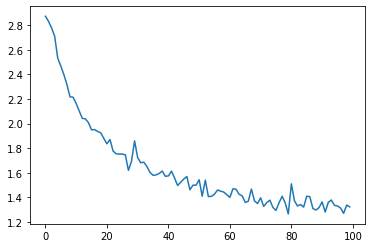

In [36]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

네트워크가 다른 카테고리에서 얼마나 잘 작동하는지 보기위해 모든 실제 언어(행)가 네트워크에서 어떤 언어로 추측(열)되는지를 나타내는 혼란 행열(confusion matrix)을 만듭니다

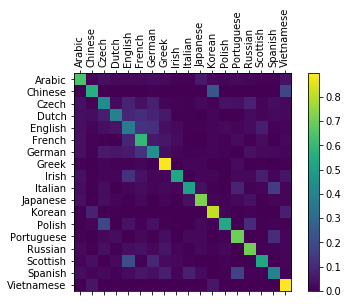

In [37]:
# 혼란 행렬에서 정확한 추측을 추적
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# 주어진 라인의 출력 반환
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# 예시들 중에 어떤 것이 정확하게 예측되었는지 기록
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# 모든 행을 합계로 나누어 정규화
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# 도식 설정
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# 축 설정
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# 모든 tick에서 레이블 지정
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

주축에서 벗어난 밝은 점을 선택하여 잘못 추측한 언어를 표시 할 수 있습니다
ex. 한국어 --> 중국어로 잘못 추측

In [38]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.67) Russian
(-1.05) Czech
(-2.24) English

> Jackson
(-0.39) English
(-2.00) Scottish
(-2.83) Russian

> Satoshi
(-0.91) Japanese
(-1.43) Polish
(-2.24) Arabic
